In [1]:
import sys
sys.path.append('..')
import os
import sklearn.metrics.cluster
import sklearn.cluster
import seaborn as sns
import scanpy as sc
import sklearn as sk
from sklearn.neighbors import NearestNeighbors
import matplotlib as mpl
from matplotlib import pyplot as plt
import skdim
import seaborn as sns
import time
import numpy as np
import pandas as pd
import pickle
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages
import utils
import anndata2ri
import gc
import benchmark_common_functions
from itertools import product
import pingouin as pg
sns.set_style('whitegrid')
anndata2ri.activate()
ro.numpy2ri.activate()
readRDS = ro.r['readRDS']
%load_ext rpy2.ipython

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def formatFloat(val):
    fmat = '%.2f'
    ret =  fmat % val
    if ret.startswith("0."):
        return ret[1:]
    if ret.startswith("-0."):
        return "-" + ret[2:]
    return ret

In [3]:
#get_res_path = lambda fname: f'{resdir}{fname}_norm{do_norm}_log{do_log}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn{n_neighbors}_seed{seed}.pkl'
#get_res_path_orig = lambda fname: f'{resdir}{fname}_orig_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn{n_neighbors}_seed{seed}.pkl'

get_res_path = lambda fname: f'{resdir}{fname}_norm{do_norm}_log{do_log}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn_sqrt_seed{seed}.pkl'
get_res_path_orig = lambda fname: f'{resdir}{fname}_orig_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn_sqrt_seed{seed}.pkl'

In [4]:
#fixed params
do_norm = False
norm_scale = True
do_log = False
do_pca = True
n_neighbors = 10
seed = 0

#vary params
metric=('cosine','euclidean')
n_comps=(25,50,100,500)
weighted=(True,)

params_list = list(product(metric,n_comps,weighted))

In [5]:
all_parsed_results_dicts = {}
filterings = ['sce_filteredExpr10','sce_filteredHVG10','sce_filteredM3Drop10','sce_full']

for filtering in filterings:
    rootdir = '../data/DuoClustering2018/'+filtering+'/'
    resdir = '../results/DuoClustering2018/'+filtering+'/'

    fnames = os.listdir(rootdir)
    fnames = [f for f in fnames if 'sce' in f and '.rds' in f]


    results_dicts = {}
    for metric,n_comps,weighted in params_list:
        results_dicts[(metric,n_comps,weighted)] = {}
        for fname in fnames:
            with open(get_res_path_orig(fname[:-4]),'rb') as f:
                results_dicts[(metric,n_comps,weighted)][fname] = pickle.load(f)

    parsed_results_dicts = {}
    for k,results_dict in results_dicts.items():
        parsed_results_dicts[k] = {}

        (parsed_results_dicts[k]['hubness_dfs'], 
         parsed_results_dicts[k]['clus'], 
         parsed_results_dicts[k]['clus_scores'],
         parsed_results_dicts[k]['clus_info']) = benchmark_common_functions.parse_results_dict(results_dict)

    all_parsed_results_dicts[filtering] = parsed_results_dicts

FileNotFoundError: [Errno 2] No such file or directory: '../results/DuoClustering2018/sce_full/sce_full_TrapnellTCC_orig_pcaTrue_ncomps25_cosine_weightedTrue_knn_sqrt_seed0.pkl'

# All res

In [ ]:
sce_key = 'sce_filteredExpr10'
parsed_results_dicts = all_parsed_results_dicts[sce_key]

clus_method = 'leiden'
metric = 'ARI'

preproc_keys = parsed_results_dicts.keys()
clus_keys = parsed_results_dicts[('cosine', 50, True)]['clus'].keys()

all_scores = {}
for it_method,hub_method in enumerate(clus_keys):
    for key in preproc_keys:
        try:
            all_scores[key][hub_method] = pd.DataFrame(benchmark_common_functions.get_key_df(parsed_results_dicts[key]['clus_scores'][hub_method],clus_method)).loc[[metric]]
            all_scores[key][hub_method].columns = [i.split('filtered')[1].split('.')[0] for i in list(all_scores[key][hub_method].columns)] 
        except:
            all_scores[key] = {}
            all_scores[key][hub_method] = pd.DataFrame(benchmark_common_functions.get_key_df(parsed_results_dicts[key]['clus_scores'][hub_method],clus_method)).loc[[metric]]
            all_scores[key][hub_method].columns = [i.split('filtered')[1].split('.')[0] for i in list(all_scores[key][hub_method].columns)] 

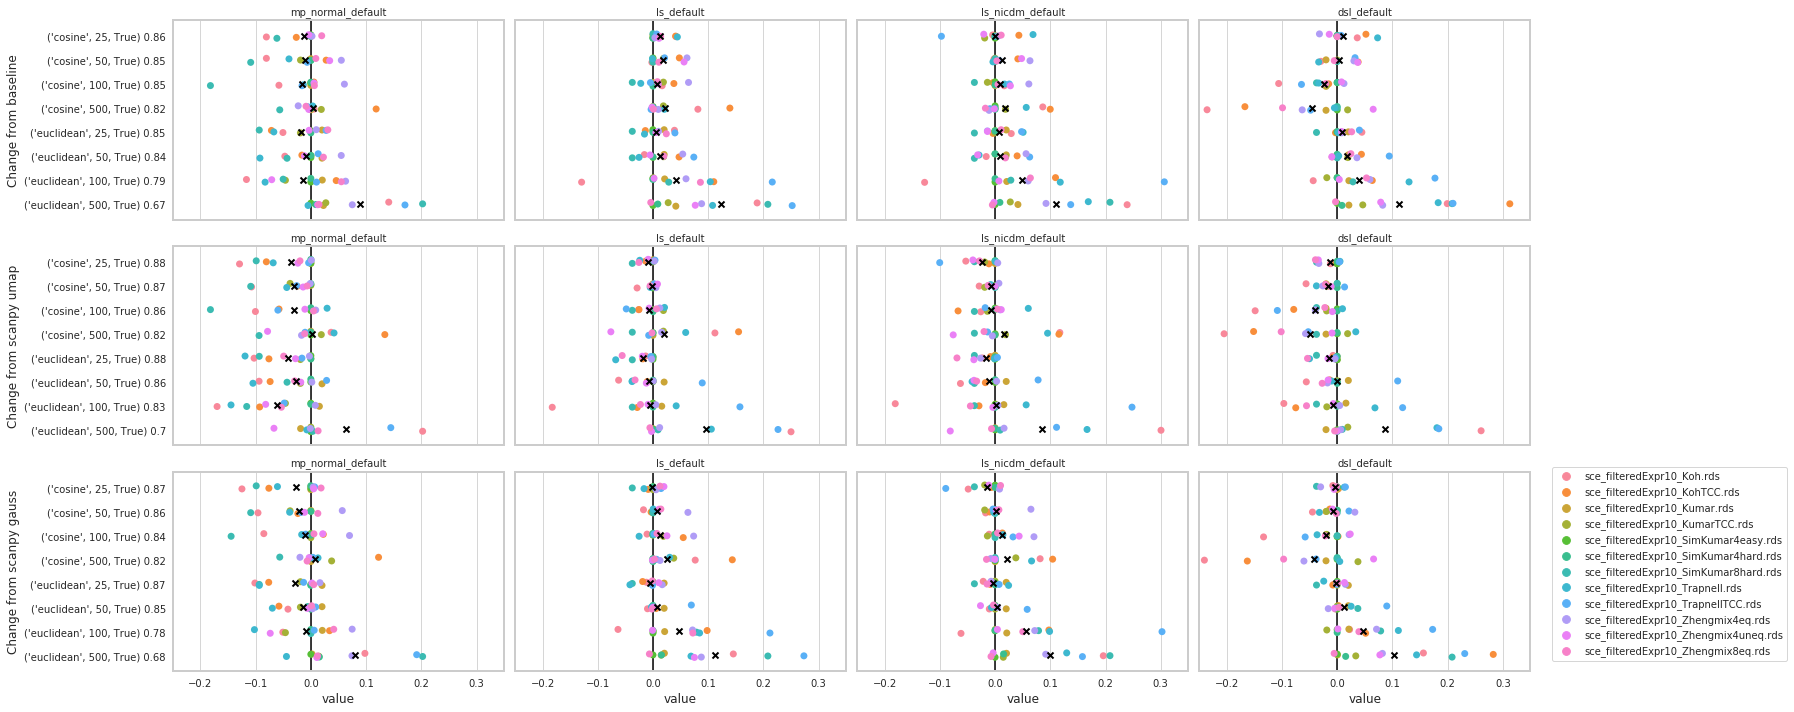

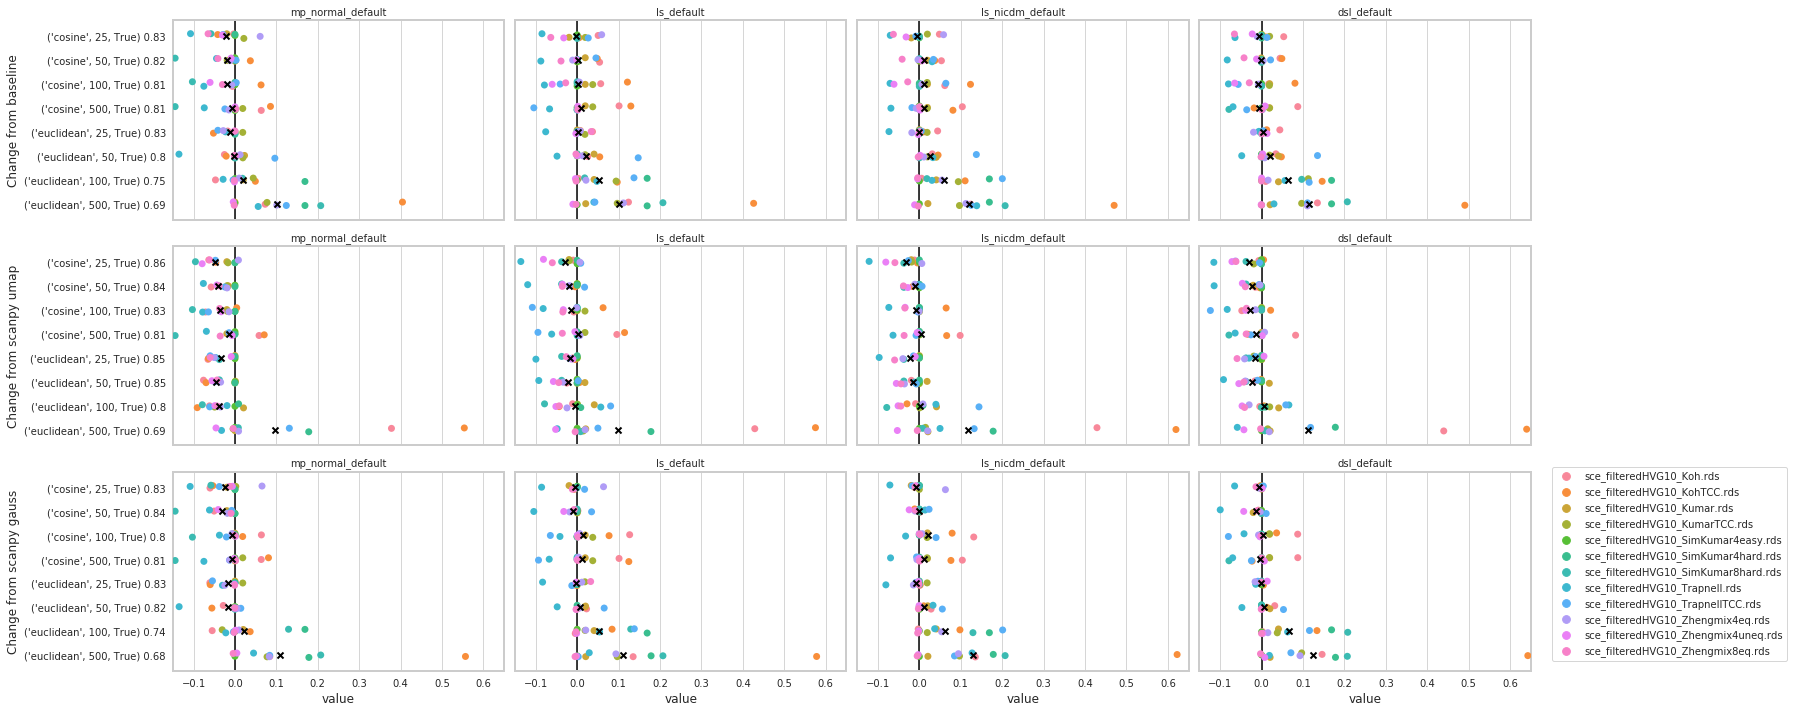

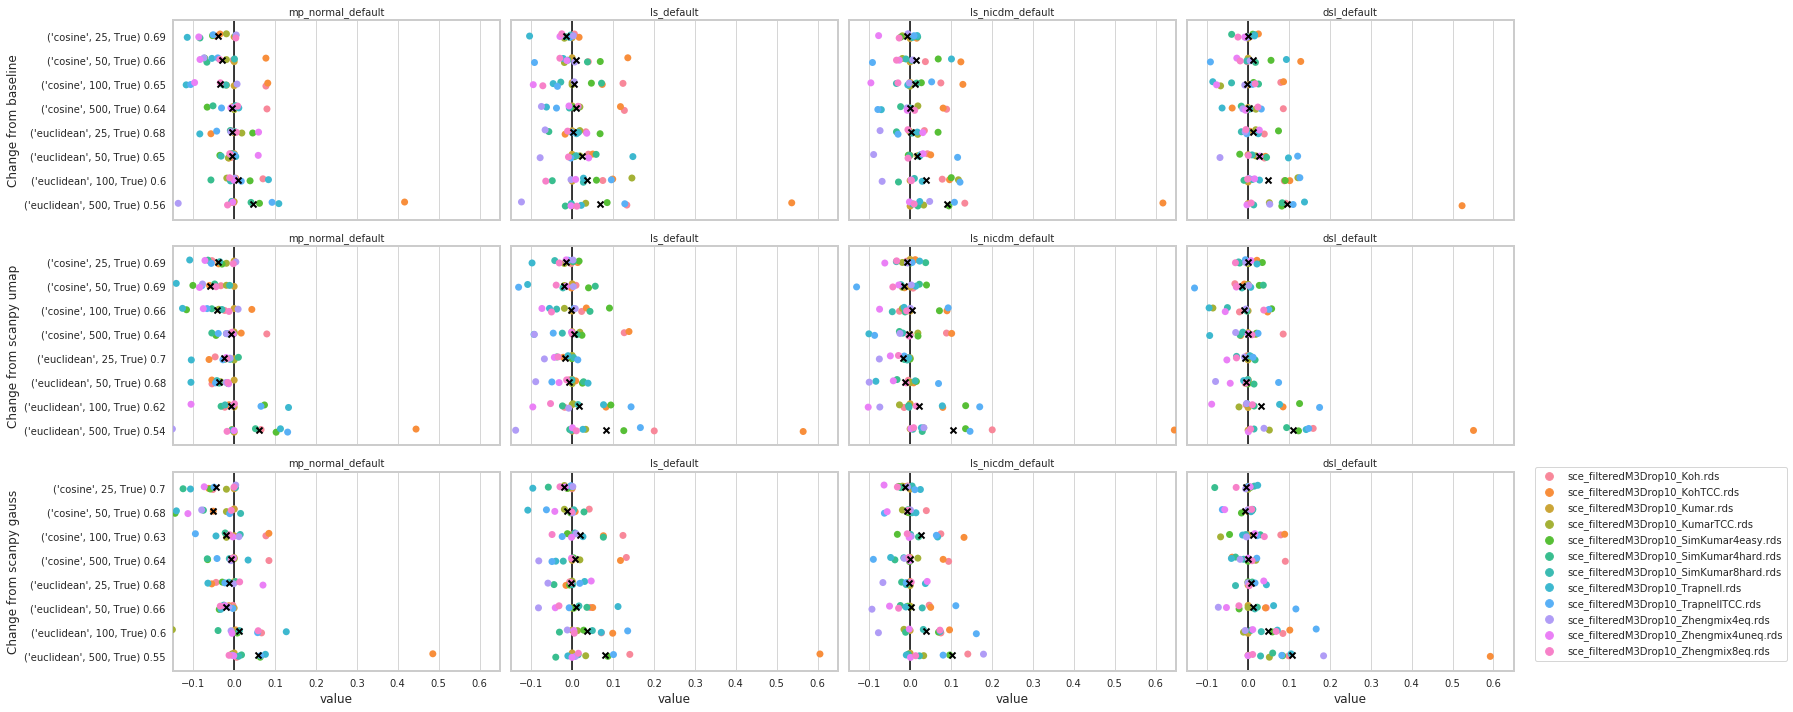

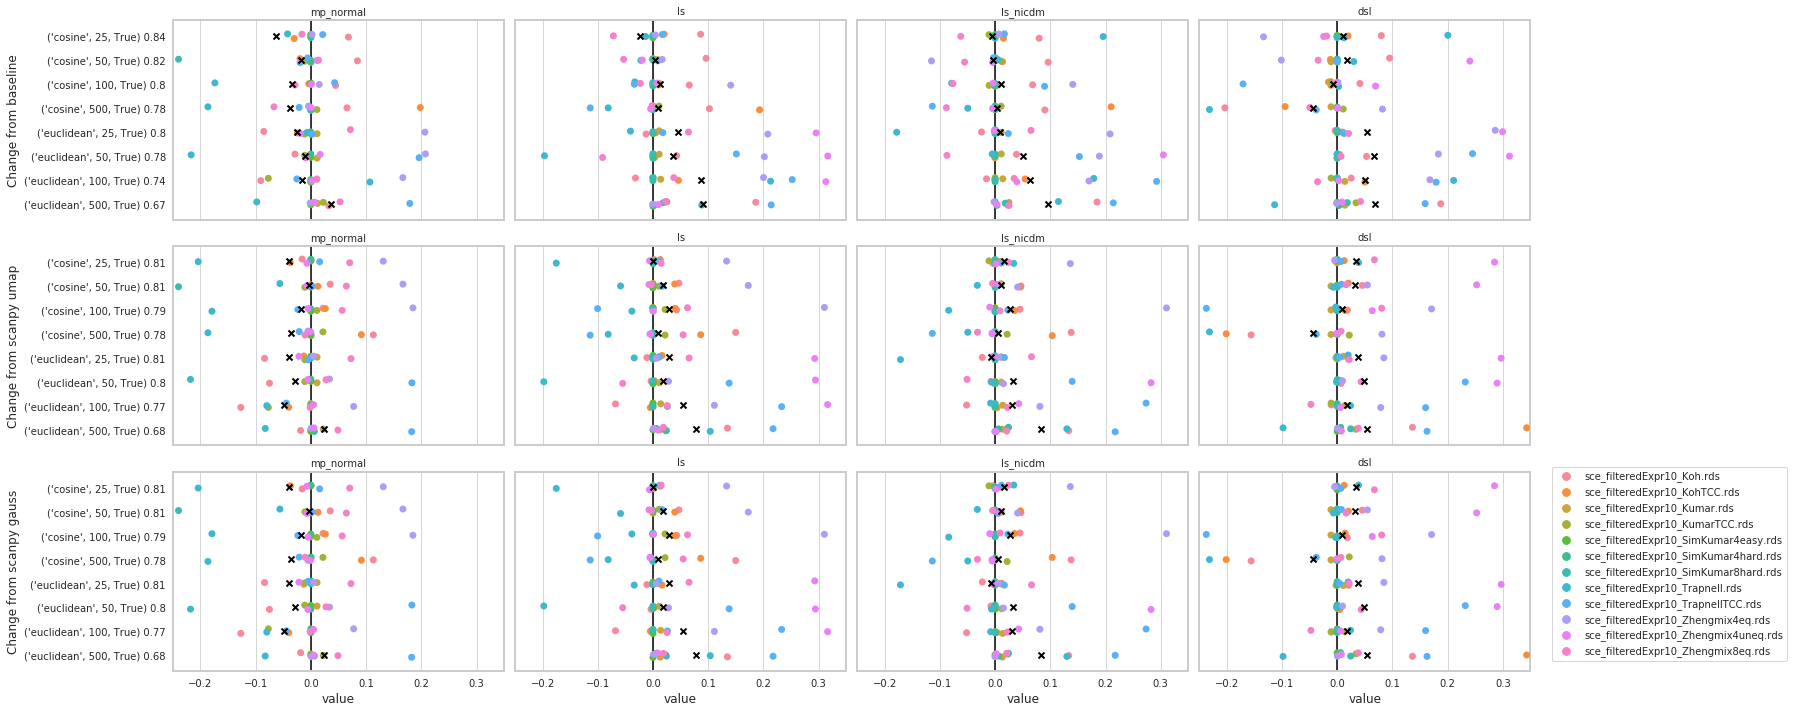

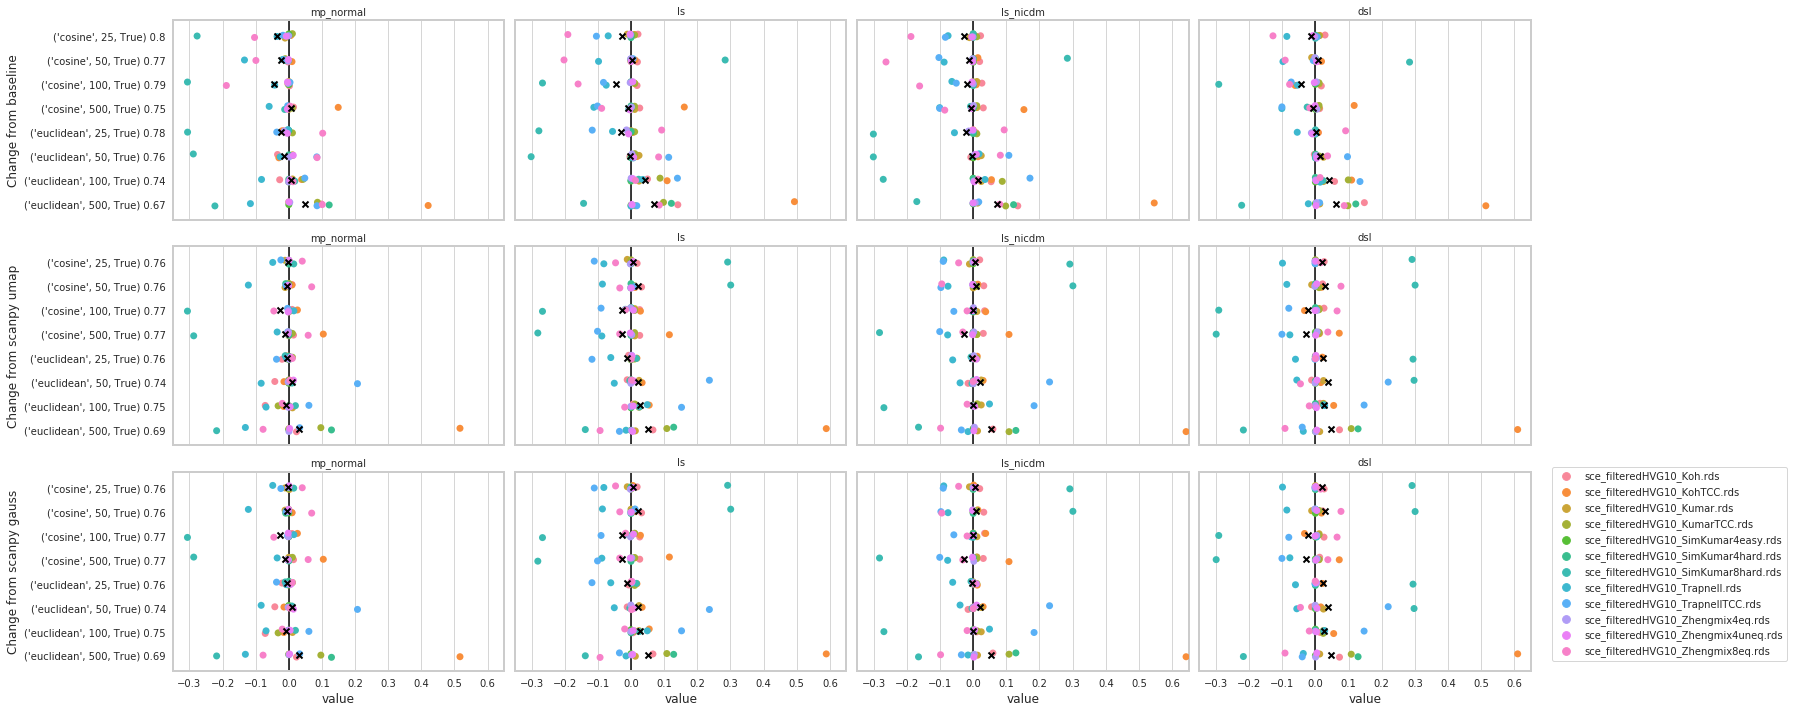

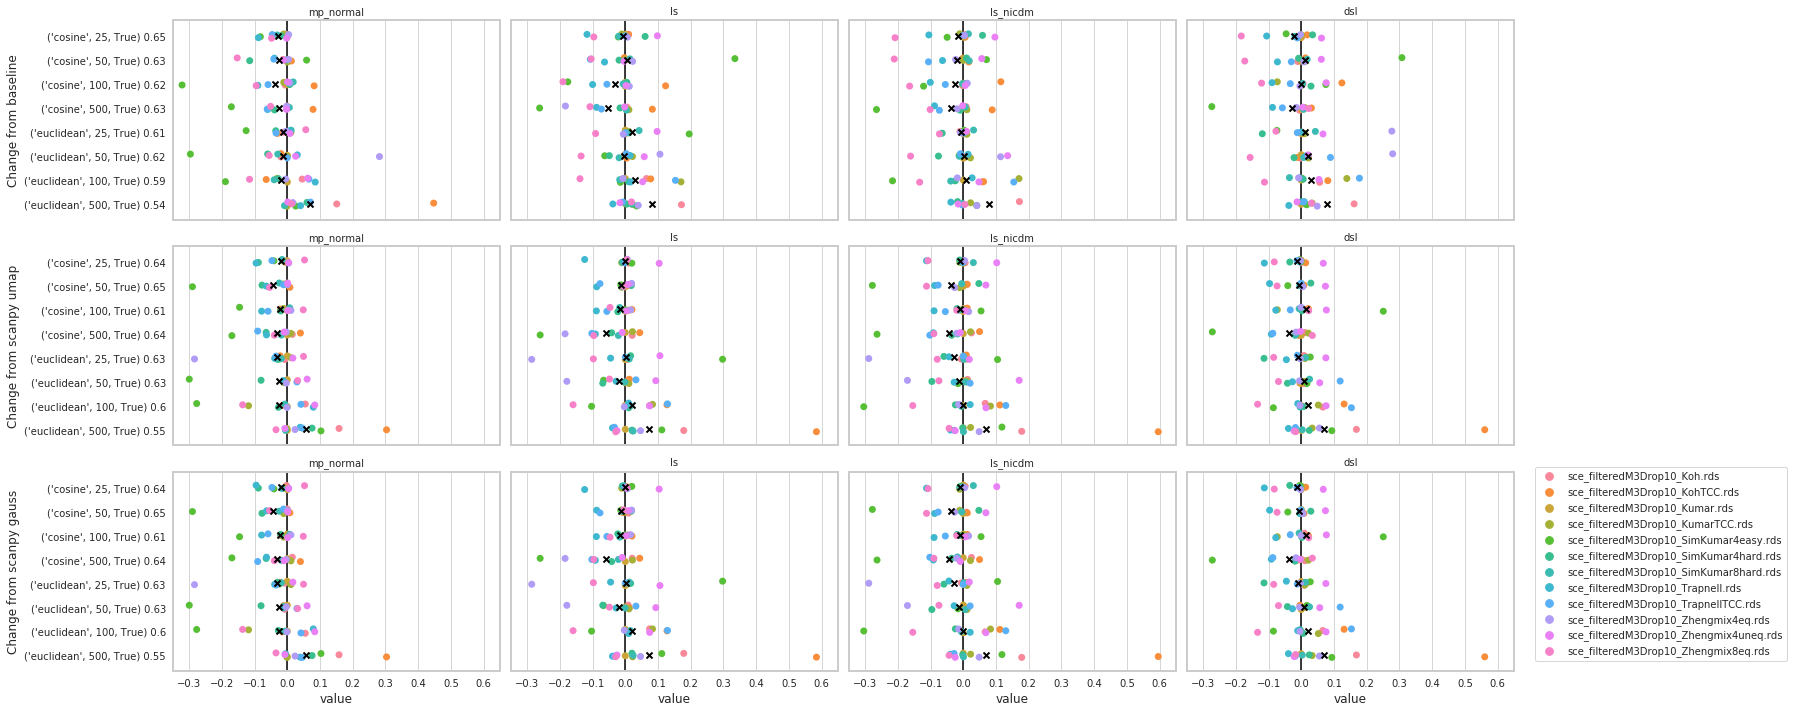

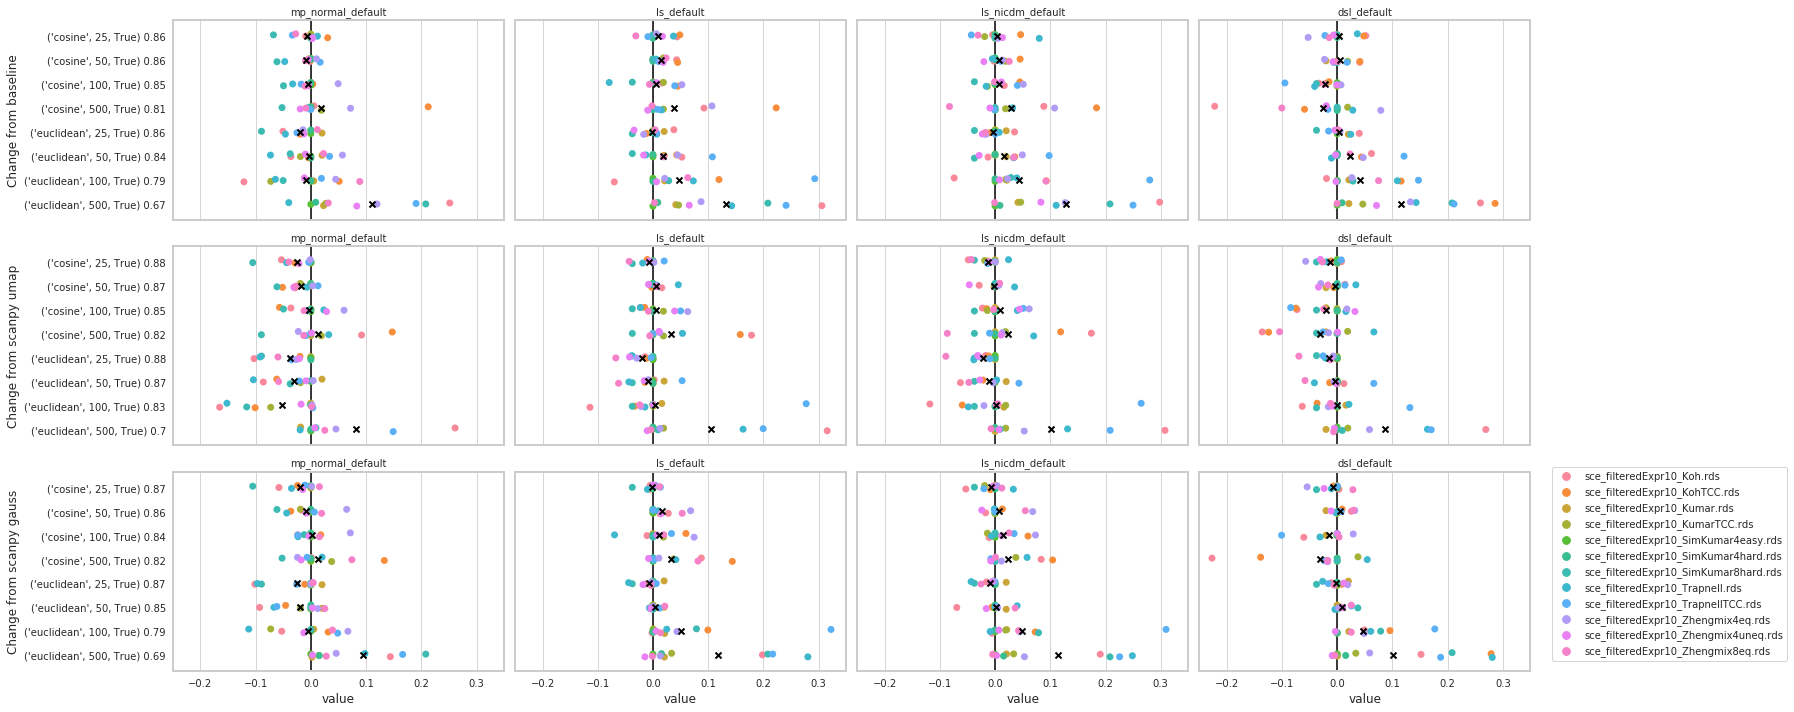

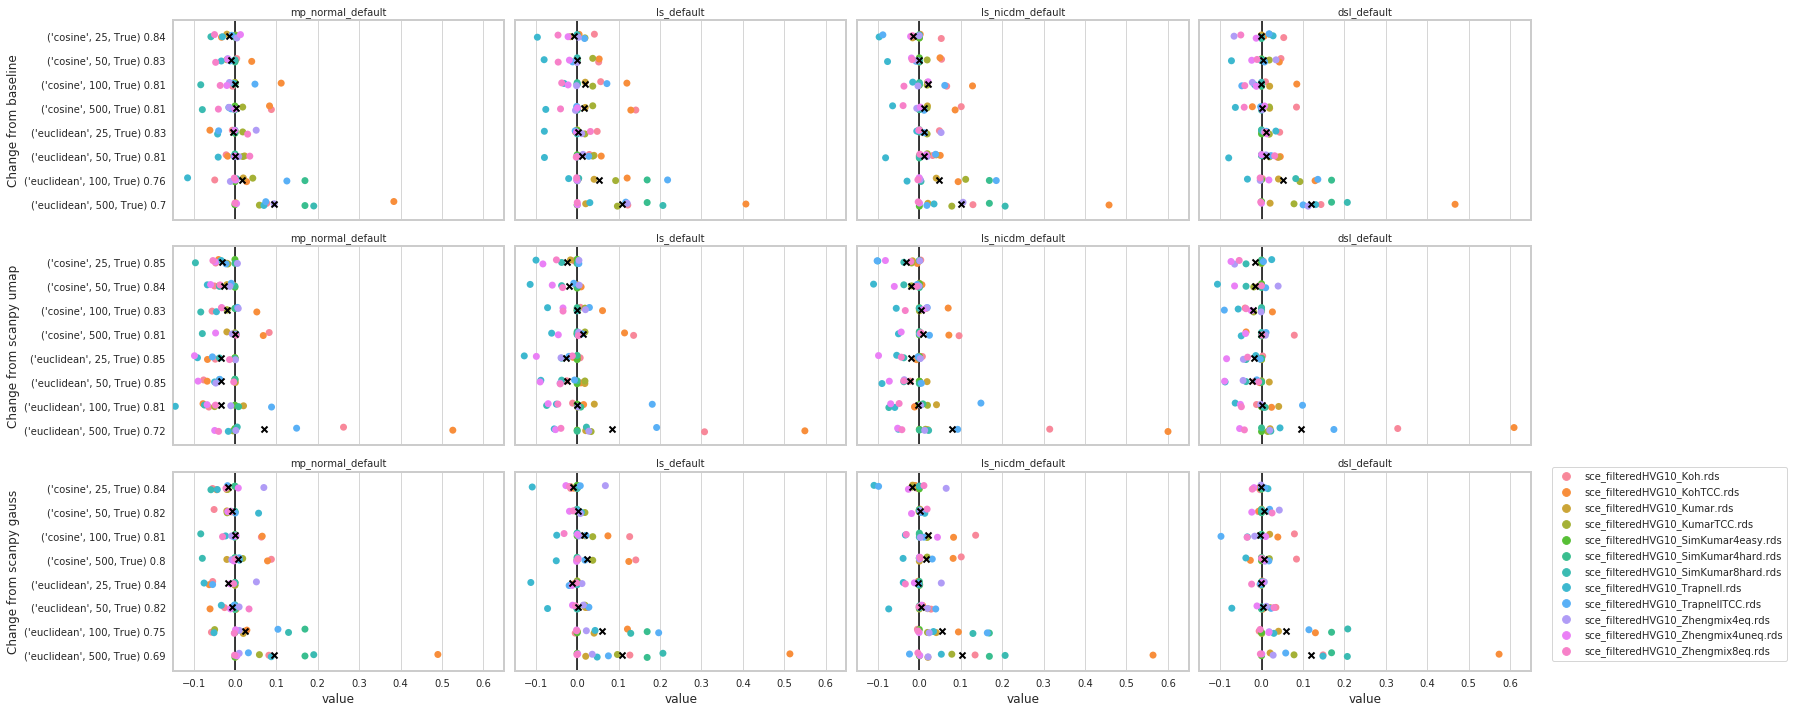

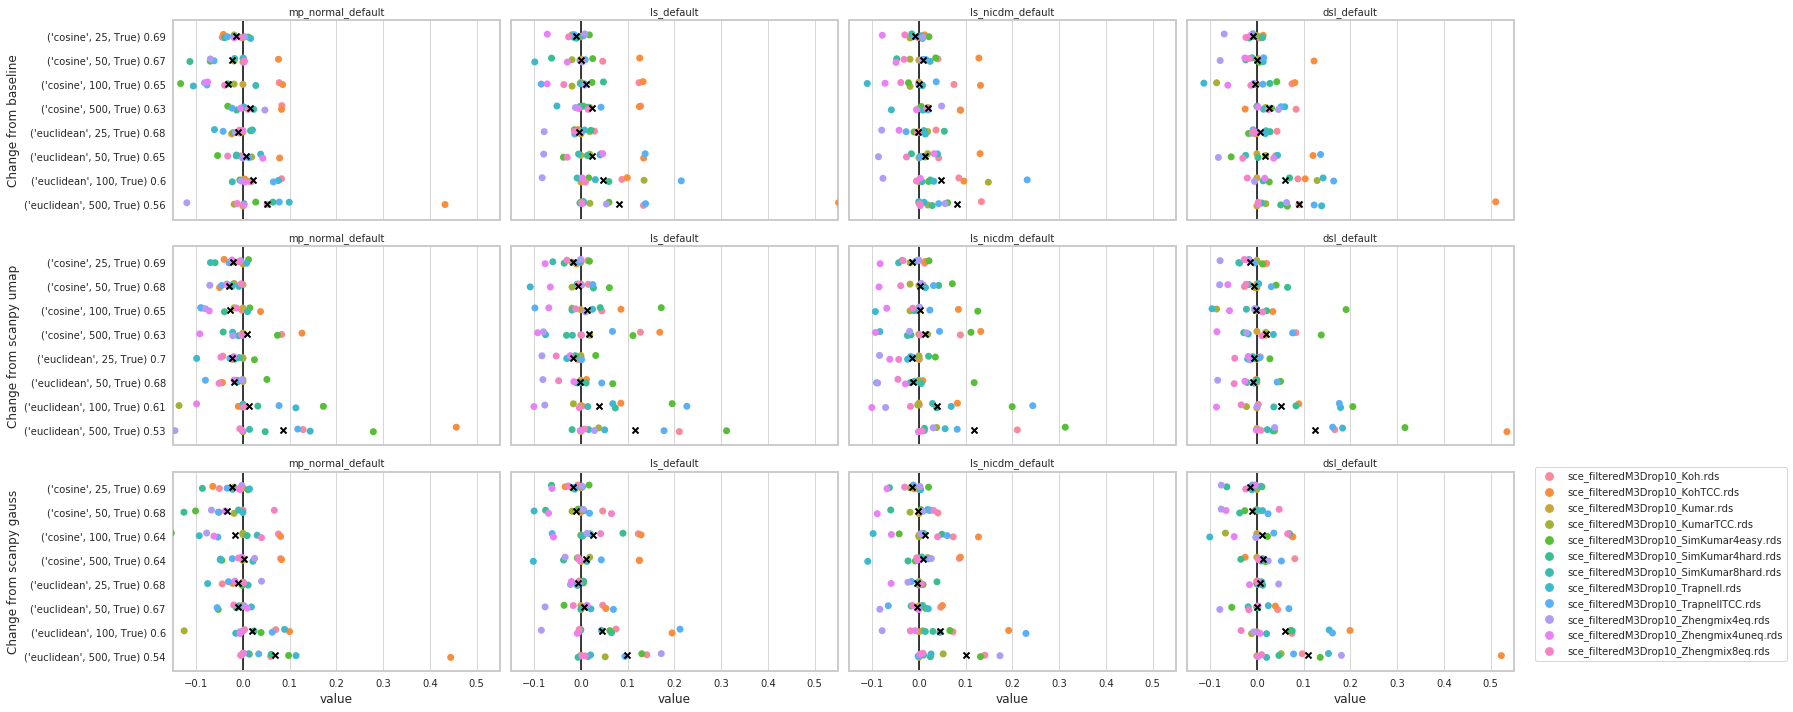

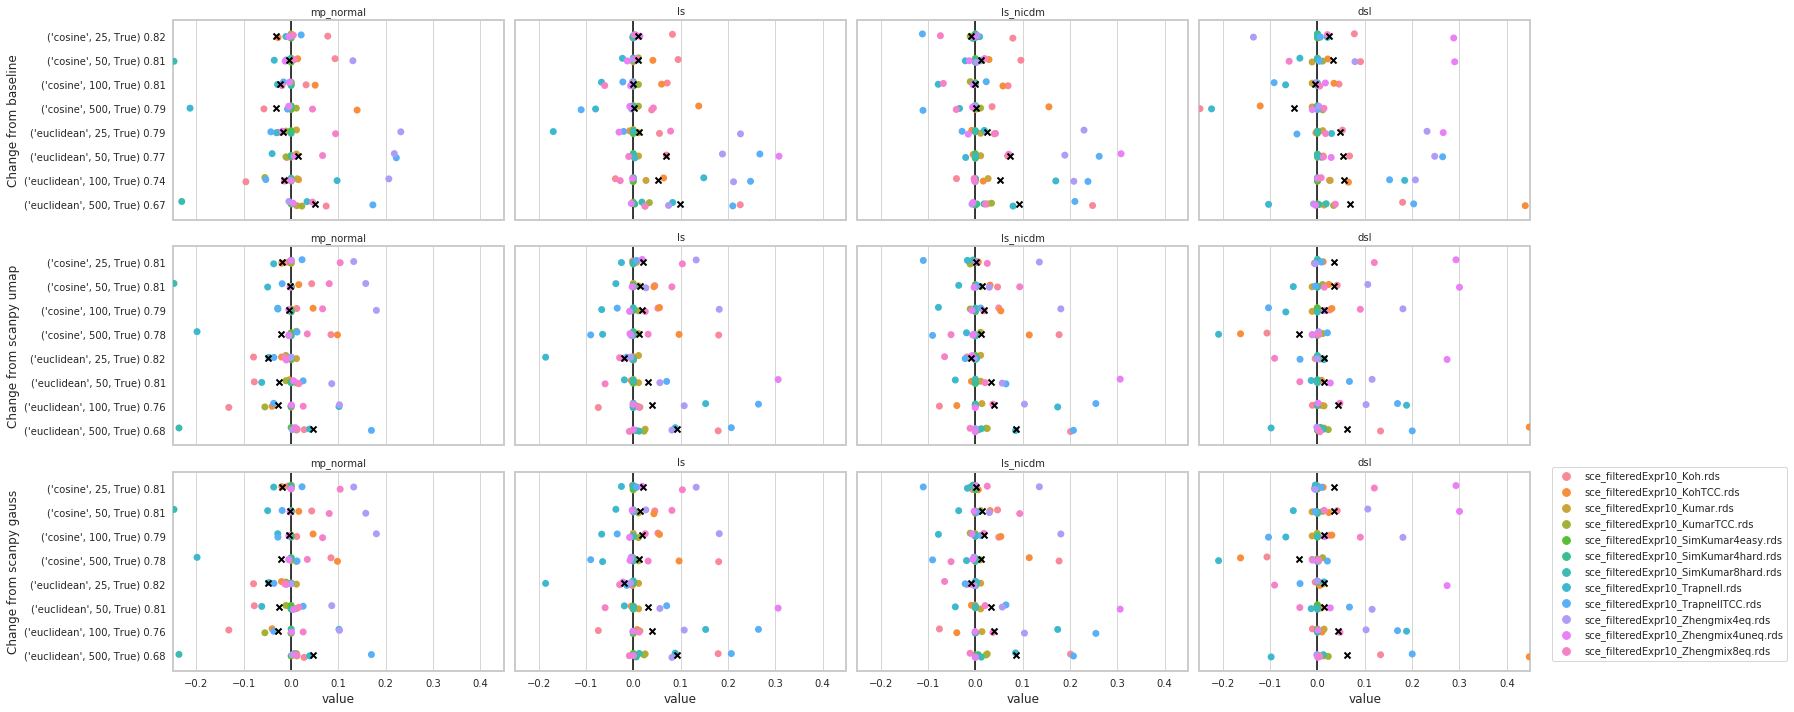

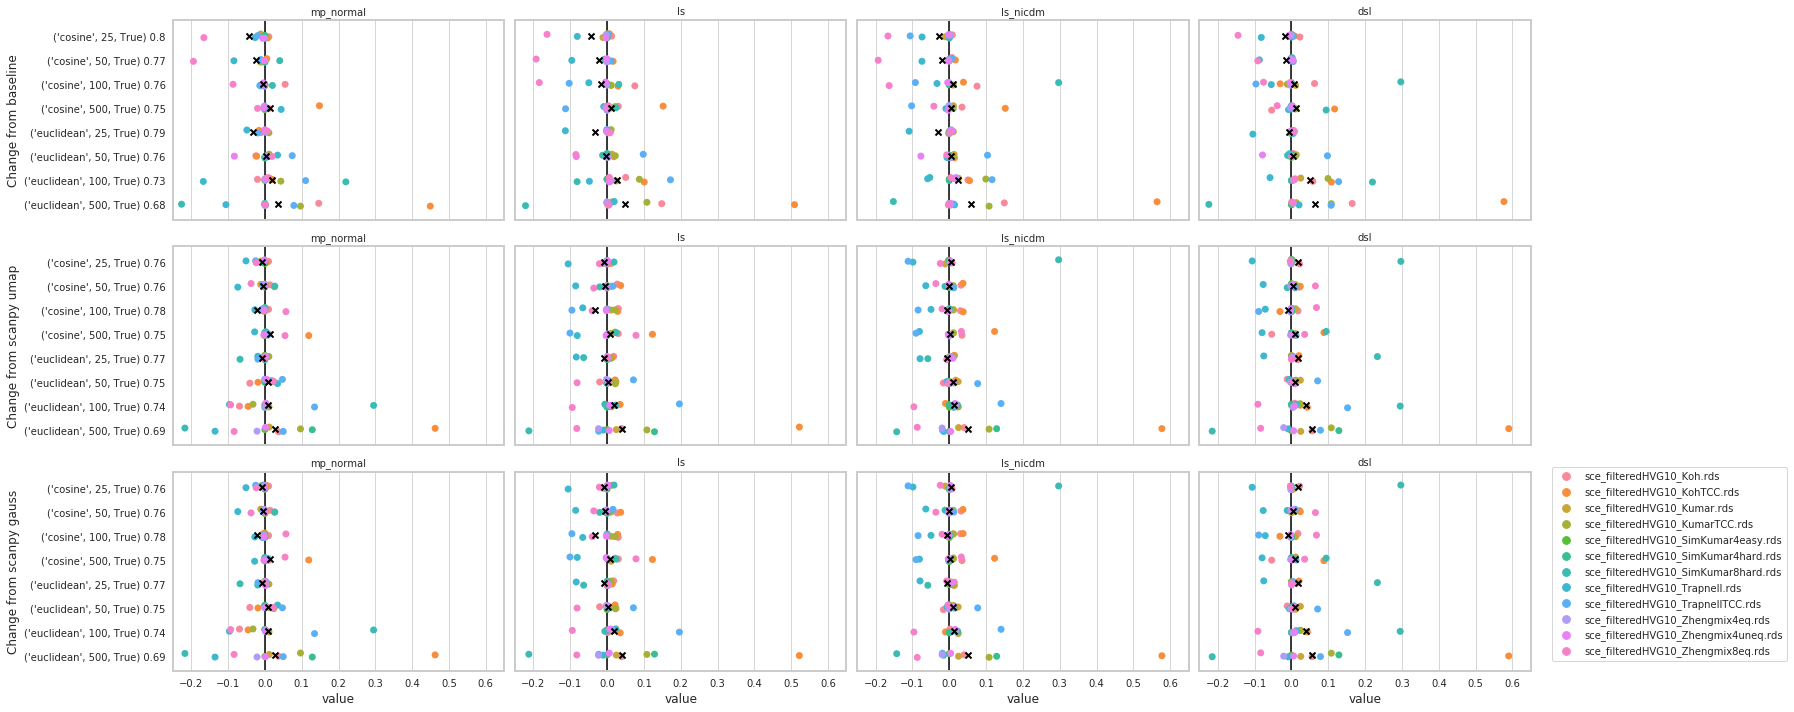

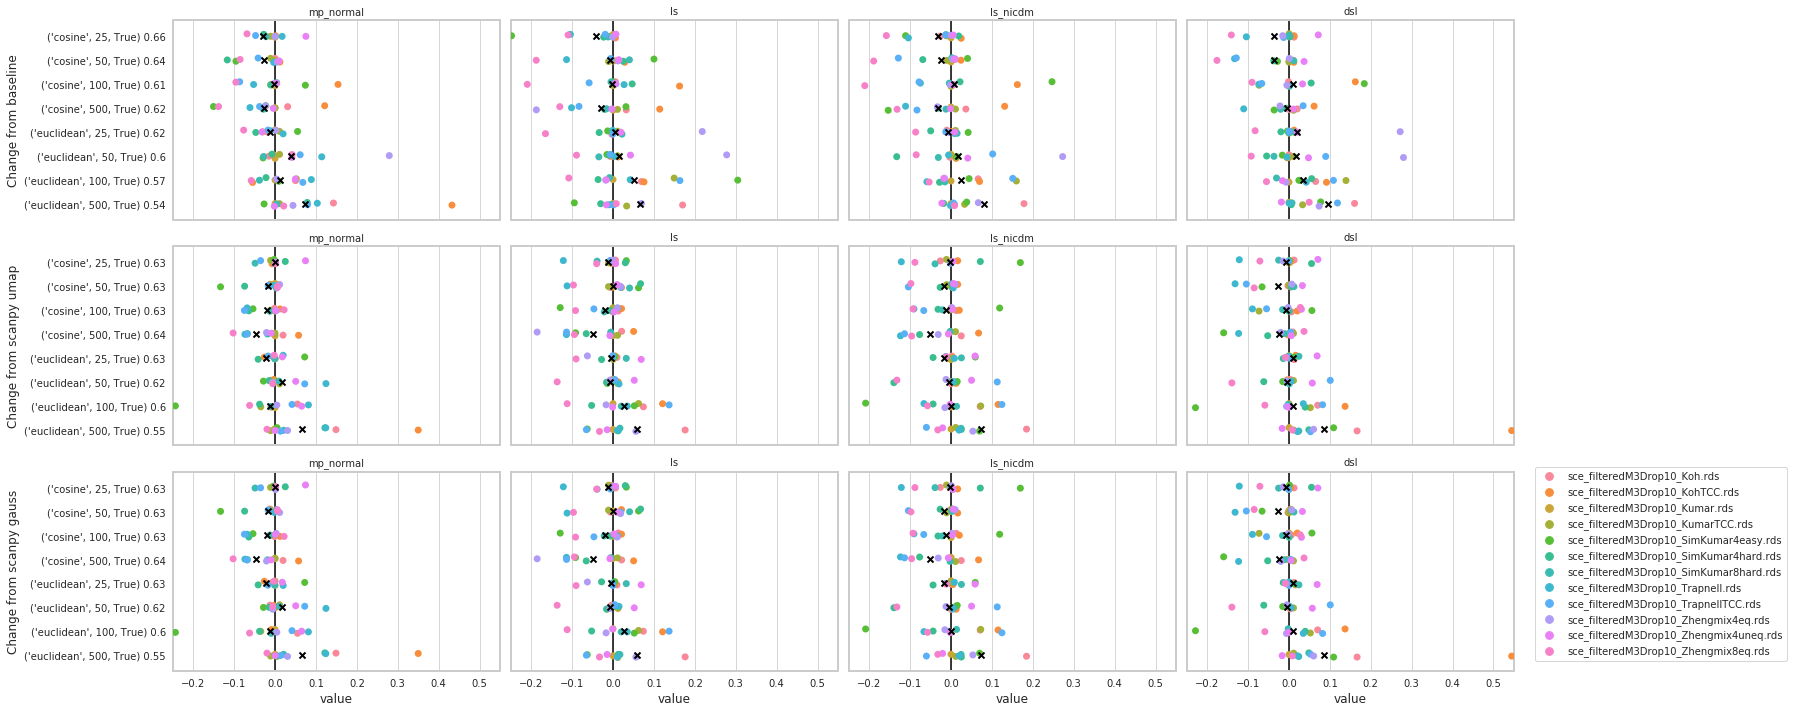

In [12]:
mpl.rcParams['axes.linewidth'] = 2
sns.set_style('whitegrid')
jitter = True

clus_methods=('leiden','louvain')
clus_metrics =('Homogeneity','ARI')
weights=(True,)
preproc=('sce_filteredExpr10','sce_filteredHVG10','sce_filteredM3Drop10')

params_list = list(product(clus_methods,clus_metrics,weights,preproc))

for clus_method,metric,weighted,sce_key in params_list:

    parsed_results_dicts = all_parsed_results_dicts[sce_key]
    preproc_keys = [i for i in parsed_results_dicts.keys() if i[2] == weighted]
    clus_keys = parsed_results_dicts[list(parsed_results_dicts.keys())[0]]['clus'].keys()

    all_scores = {}
    for it_method,hub_method in enumerate(clus_keys):
        for key in preproc_keys:
            try:
                all_scores[key][hub_method] = pd.DataFrame(benchmark_common_functions.get_key_df(parsed_results_dicts[key]['clus_scores'][hub_method],clus_method)).loc[[metric]]
                all_scores[key][hub_method].columns = [i.split('filtered')[1].split('.')[0] for i in list(all_scores[key][hub_method].columns)] 
            except:
                all_scores[key] = {}
                all_scores[key][hub_method] = pd.DataFrame(benchmark_common_functions.get_key_df(parsed_results_dicts[key]['clus_scores'][hub_method],clus_method)).loc[[metric]]
                all_scores[key][hub_method].columns = [i.split('filtered')[1].split('.')[0] for i in list(all_scores[key][hub_method].columns)] 


    hub_methods_adjusted_param = ['mp_normal', 'ls', 'ls_nicdm', 'dsl']
    ref_methods_adjusted_param = ['base','scanpy_umap','scanpy_gauss']

    hub_methods_default_param = ['mp_normal_default','ls_default','ls_nicdm_default','dsl_default']
    ref_methods_default_param = ['base_default','scanpy_default_umap','scanpy_default_gauss']

    if metric == 'ARI': 
        hub_methods = hub_methods_adjusted_param
        ref_methods = ref_methods_adjusted_param
    else:
        hub_methods = hub_methods_default_param
        ref_methods = ref_methods_default_param

    f,axs = plt.subplots(3,4,figsize=(25,10),sharey='row',sharex='all')
    #plt.suptitle(f"{clus_method} - {metric}",y=1.02)
    xtickstep = .1

    for i,hub_method in enumerate(hub_methods):
        for j,reference_method in enumerate(ref_methods):

            ref_scores = {}
            for key in preproc_keys:
                mean_score_key = str(round(np.mean(pd.DataFrame(benchmark_common_functions.get_key_df(parsed_results_dicts[key]['clus_scores'][reference_method],clus_method)).loc[metric]),2))
                ref_scores[str(key)] = (pd.DataFrame(benchmark_common_functions.get_key_df(parsed_results_dicts[key]['clus_scores'][hub_method],clus_method)) 
                                   - pd.DataFrame(benchmark_common_functions.get_key_df(parsed_results_dicts[key]['clus_scores'][reference_method],clus_method))).loc[[metric]].assign(metric=str(key)+' '+mean_score_key)

            cdf = pd.concat(ref_scores)                               # CONCATENATE
            mdf = pd.melt(cdf, id_vars=['metric'], var_name=['dataset']) 

            axs[j,i].set_title(hub_method)
            axs[j,i].axvline(c='k')
            _ = sns.stripplot(x="value", y="metric", hue="dataset", data=mdf, jitter=jitter,ax=axs[j,i],s=7)  # RUN PLOT
            #mdf['dataset']='ARI'
            #_ = sns.boxplot(x="value", y="metric", hue="dataset", data=mdf, showmeans=1, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, ax=axs[j,i])  # RUN PLOT   

            _.legend(bbox_to_anchor=(1.5, 1.5),loc='upper right',borderaxespad=0.)
            _min = np.round(cdf.iloc[:,:-1].min().min(),1)
            _max = np.round(cdf.iloc[:,:-1].max().max(),1)
            _.set_xlim(_min-.05,_max+.05)
            _.set_xticks(np.arange(_min,_max+.05,xtickstep))
            means = [np.mean(v.iloc[0,:-1]) for v in ref_scores.values()]
            sns.scatterplot(x=means,y=np.arange(len(ref_scores)),marker='x',color='k',linewidth=2,ax=axs[j,i],zorder=100)


        if i < 4:
            axs[0,i].get_legend().remove()
        if i == 0:
            axs[0,i].set_ylabel('Change from baseline')
            axs[1,i].set_ylabel('Change from scanpy umap')
            axs[2,i].set_ylabel('Change from scanpy gauss')
        else:
            axs[0,i].yaxis.label.set_visible(False)
            axs[1,i].yaxis.label.set_visible(False)
            axs[2,i].yaxis.label.set_visible(False)

        axs[1,i].get_legend().remove()
        axs[2,i].get_legend().remove()

        axs[0,i].xaxis.label.set_visible(False)
        axs[1,i].xaxis.label.set_visible(False)

    plt.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'../figures/{sce_key}_duo_original_{clus_method}_{metric}_weighted_{weighted}.png', dpi=300)
    plt.show()